In [ ]:
!git clone 'https://github.com/LuchnikovI/Dynamic-mode-decomposition-for-open-quantum-systems-identification'
%cd 'Dynamic-mode-decomposition-for-open-quantum-systems-identification'
import math
import tensorflow as tf
import matplotlib.pyplot as plt

from nmd_finite_env import FiniteEnv
from embedding import Embedding

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


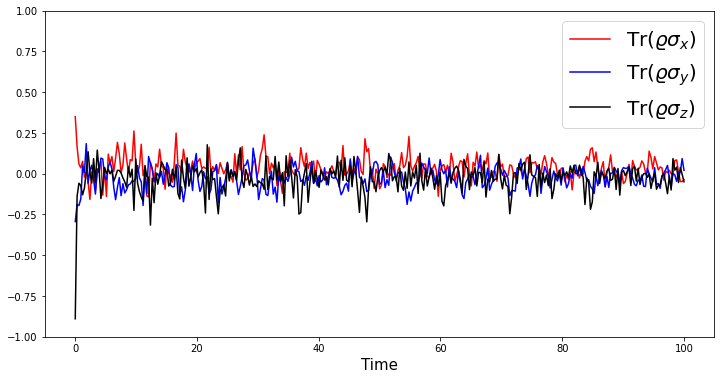

In [30]:
#------------------------Parameters------------------------#
dissipation_ampl = 0.001 # amplitude of dissipation
hamiltonian_ampl = 1 # amplitude of the hamiltonian part
time_step = 0.3  # time step size
total_time = 100  # total simulation time
number_of_lines = 10  # number of parallel experiments
size_of_mem = 6  # memory size
#----------------------------------------------------------#

# pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = 1j * tf.constant([[0, -1], [1, 0]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# all pauli matrices in one tensor
pauli = tf.concat([sigma_x[tf.newaxis],
                   sigma_y[tf.newaxis],
                   sigma_z[tf.newaxis]], axis=0)

# model initializing
model = FiniteEnv(2, size_of_mem)
model.set_rand_gen(dissipation_ampl, hamiltonian_ampl)

# random pure initial states
psi_re = tf.random.normal((2 * number_of_lines, 2), dtype=tf.float64)
psi_im = tf.random.normal((2 * number_of_lines, 2), dtype=tf.float64)
psi = tf.complex(psi_re, psi_im)
psi = psi / tf.linalg.norm(psi, axis=1, keepdims=True)
rho = psi[:, tf.newaxis] * tf.math.conj(psi)[..., tf.newaxis]

# dynamics simulation
dynamics = model.dynamics(total_time, time_step, rho)
train_set = dynamics[:number_of_lines]
test_set = dynamics[number_of_lines:]
X_train = tf.tensordot(train_set, pauli, [[2, 3], [2, 1]])

# plotting some dynamics
time = tf.linspace(0, total_time, X_train.shape[1])
plt.figure(figsize=(12, 6))
plt.plot(time, X_train[0, :, 0], 'r')
plt.plot(time, X_train[0, :, 1], 'b')
plt.plot(time, X_train[0, :, 2], 'k')
plt.ylim(top=1, bottom=-1)
plt.xlabel('Time', fontsize=15)
plt.legend([r'${\rm Tr}(\varrho \sigma_x)$',
            r'${\rm Tr}(\varrho \sigma_y)$',
            r'${\rm Tr}(\varrho \sigma_z)$'], fontsize=20)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/

Minimal rank = 136
True rank = 144


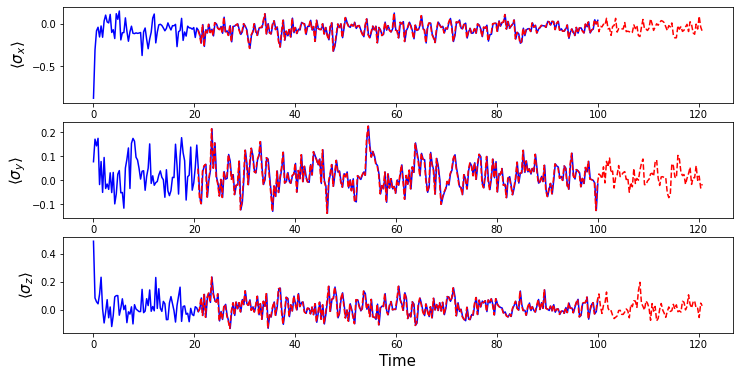

In [32]:
#------------------------Parameters--------------------------#
K = 70  # memory depth
eps = 1e-4  # tolerance
u = tf.eye(2, dtype=tf.complex128)  # control signal
ind = 10  # discrete time moment when to apply control signal
#------------------------------------------------------------#

# embedding
emb = Embedding()
# learn embedding
emb.learn(train_set, K, eps)
# min rank
min_rank = emb.min_rank
# true rank
true_rank = (emb.mem_dim ** 2) * (emb.sys_dim ** 2)
# prediction
prediction = emb.predict(test_set[0, :K],
                         test_set.shape[1], 
                         ind, u)
# corresponding bloch vectors
X_predicted = tf.tensordot(prediction, pauli, [[1, 2], [2, 1]])
# test bloch vectors
X_test = tf.tensordot(test_set, pauli, [[2, 3], [2, 1]])


# plotting
time = tf.linspace(0, total_time, X_test.shape[1])
plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(time, X_test[0, :, 0], 'b')
plt.plot(time + (K - 1) * time_step, X_predicted[:, 0], 'r--')
plt.ylabel(r'$\langle\sigma_x\rangle$', fontsize=15)
plt.subplot(312)
plt.plot(time, X_test[0, :, 1], 'b')
plt.plot(time + (K - 1) * time_step, X_predicted[:, 1], 'r--')
plt.ylabel(r'$\langle\sigma_y\rangle$', fontsize=15)
plt.subplot(313)
plt.plot(time, X_test[0, :, 2], 'b')
plt.plot(time + (K - 1) * time_step, X_predicted[:, 2], 'r--')
plt.xlabel('Time', fontsize=15)
plt.ylabel(r'$\langle\sigma_z\rangle$', fontsize=15)
print('Minimal rank = {}'.format(min_rank))
print('True rank = {}'.format(4 * size_of_mem ** 2))